In [1]:
content_path = '/kaggle/input/mona-lisa/mona_lisa.jpeg'
style_path = '/kaggle/input/starry-night/starry_night.jpeg'

In [2]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import functools
import IPython.display


import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Visualization of Content & Style Image


In [3]:
def load_image(path):
    
    img = Image.open(path)
    max_dim_image = max(img.size)
    max_dims = 512   #to make image compatible to a batch dimension

    scale_value = max_dims/max_dim_image

    img = img.resize((round(img.size[0]*scale_value), round(img.size[1]*scale_value)), Image.LANCZOS)
    
    img = tf.keras.utils.img_to_array(img)

    img = np.expand_dims(img, axis = 0)  #casting it in a batch shape (x,y,z)

    return img


In [4]:
def imshow(img, label = None):
    
    #squeezing the batch dimension of size 1
    out = np.squeeze(img, axis = 0)
    out = out.astype(np.uint8) #normalising the array entries to (0,255)
    plt.imshow(out)
    if label is not None:
        plt.title(label)
    
    plt.imshow(out)

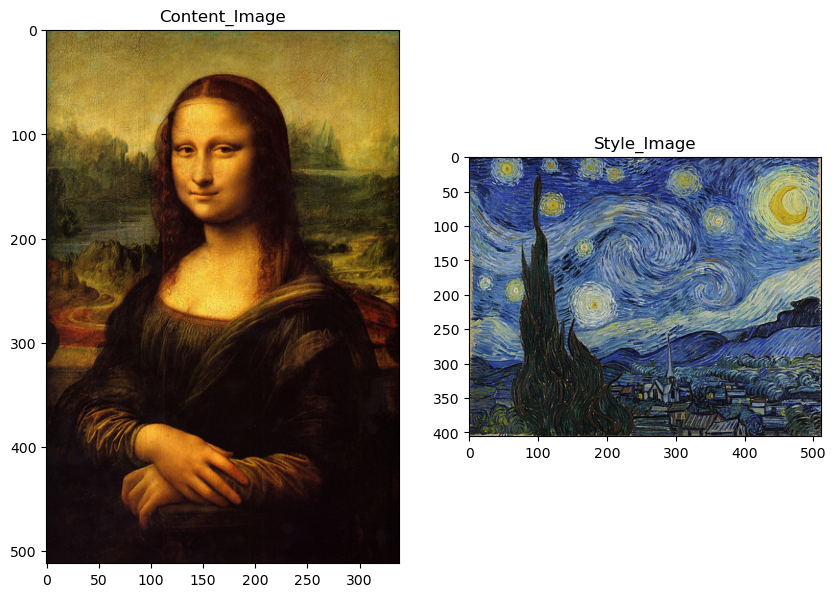

In [5]:
plt.figure(figsize= (10,10))

content = load_image(content_path).astype(np.uint8)
style = load_image(style_path).astype(np.uint8)

plt.subplot(1,2,1)
imshow(content, 'Content_Image')

plt.subplot(1,2,2)
imshow(style, 'Style_Image')
plt.show()

# DATA PROCESSING


In [6]:
def load_process_img(path):
    img = load_image(path)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [7]:
def invert_process(processed_img):
    x = processed_img.copy()

    x = np.squeeze(x,0) #squeezing the batch_dimension
    
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]   #reversing the entries of the array

    x = np.clip(x,0,255).astype(np.uint8)
    return x

In [8]:
invert_process(load_process_img(style_path)).shape  #checking shape

(406, 512, 3)

In [9]:
#content layer from which feature map will be pulled, set according to the research paper
content_layer = ['block4_conv2']      
                                        

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]

num_content_layer = len(content_layer)
num_style_layers = len(style_layers) 

# Model


In [10]:
def get_model():

    vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet') #removing fully connected layers or called 'top'
    vgg.trainable = False #Pre trained

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_output = [vgg.get_layer(name).output for name in content_layer]

    model_outputs = style_outputs + content_output

    return tf.keras.models.Model(vgg.input, model_outputs)

In [11]:
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [12]:
def gram_matrix(input_tensor):
  # Firstly making the image channels  
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)


def style_loss(base, gram_target):

    height, width, channels = base.get_shape().as_list()
    gram_style = gram_matrix(base)
    
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [13]:
def get_feature_representations(model, content_path, style_path):

    content_image = load_process_img(content_path)
    style_image = load_process_img(style_path)

    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [style_layer for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_lyr for content_lyr in content_outputs[num_style_layers:]]

    return style_features, content_features

In [14]:
def compute_loss(model,base_img, gram_style_features, content_features, alpha, beta):
    
    model_outputs = model(base_img)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0.0
    content_score = 0.0
    
    #weighing equally the contribution of the loss of each layer 
    
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * style_loss(comb_style[0], target_style)

    weight_per_content_layer = 1.0 / float(num_content_layer)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score +=  weight_per_content_layer * content_loss(comb_content[0], target_content)
        
    #the ratio of alpha/beta (1e^-3 or 1e^-4) generally, this ratio dictates the output.
    loss = (alpha * content_score) + (beta * style_score)  

    return loss, style_score, content_score


def compute_gradients(dic):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**dic)
    
    total_loss = all_loss[0]

    return tape.gradient(total_loss, dic['base_img']), all_loss

In [15]:
def style_transfer(content_path,
                       style_path,
                       num_iterations = 1200):
    
    #creating an input call to choose the degree of style transfer 
    print('Please choose a degree from {1,2,3}\n\n')
    input_int = int(input("Choose the degree of style transfer: "))
    
    if input_int == 1:
        alpha = 1e-3
        beta = 1
    
    elif input_int == 2:
        alpha = 1e-4
        beta = 1
    
    elif input_int == 3:
        alpha = 1e-4
        beta = 10
    
    else:
        raise ValueError("Choose a degree from {1,2,3} only!")
        
    
    model = get_model()
    for layer in model.layers:
        layer.trainable = False # we don't want to train layers, hence set to false

    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

    base_img = load_process_img(content_path)
    base_img = tf.Variable(base_img, dtype = tf.float32)

    opt = tf.optimizers.Adam(learning_rate= 1, epsilon = 1e-6)

    iter_count = 1

    best_loss, best_img = float('inf'), None

    dic = {
        'model' : model,
        'base_img' : base_img,
        'gram_style_features': gram_style_features,
        'content_features' : content_features,
        'alpha' : alpha,
        'beta' : beta
     }

    num_rows = 2
    num_cols = 3
    display_inteval = num_iterations / (num_rows * num_cols)

    norm_means = np.array([103.939, 116.779, 123.68]) 
    min_vals = - norm_means
    max_vals = 255 - norm_means

    imgs = []

    for i in range(num_iterations):
        grads, all_loss = compute_gradients(dic)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, base_img)])
        clipped = tf.clip_by_value(base_img, min_vals, max_vals)
        base_img.assign(clipped)

        if loss < best_loss:
            best_loss = loss
            best_img = invert_process(base_img.numpy())

        if i % display_inteval == 0:

            plot_img = base_img.numpy()
            plot_img = invert_process(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait = True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))
            print('Total Loss: {:.4e}, '
                  'style loss: {:.4e}, '
                  'content loss: {: .4e}, '
                  .format(loss, style_score, content_score))

    IPython.display.clear_output(wait = True)
    plt.figure(figsize= (14,4))
    for i, img in enumerate(imgs):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss                

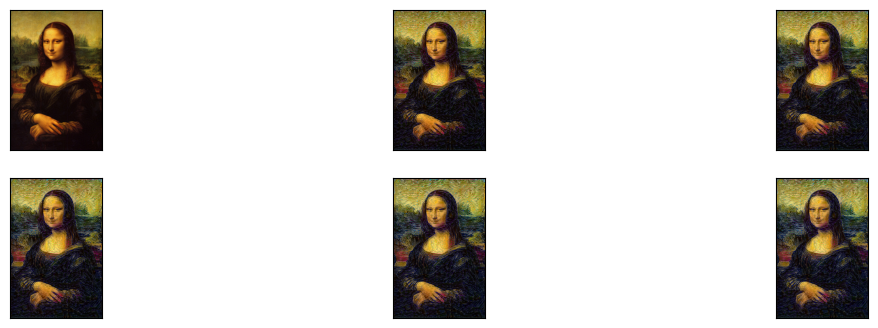

In [16]:
#choose a degree from [1,2,3]; higher the value of degree, higher the style imposition
best, best_loss = style_transfer(content_path, style_path)

In [17]:
def show_results(best_img, content_path, style_path, show_large_final=True):
  plt.figure(figsize=(10, 5))
  content = load_image(content_path)
  style = load_image(style_path)

  plt.subplot(1, 2, 1)
  imshow(content, 'Content Image')

  plt.subplot(1, 2, 2)
  imshow(style, 'Style Image')

  if show_large_final:
    plt.figure(figsize=(10, 10))

    plt.imshow(best_img)
    plt.title('Output Image')
    plt.show()

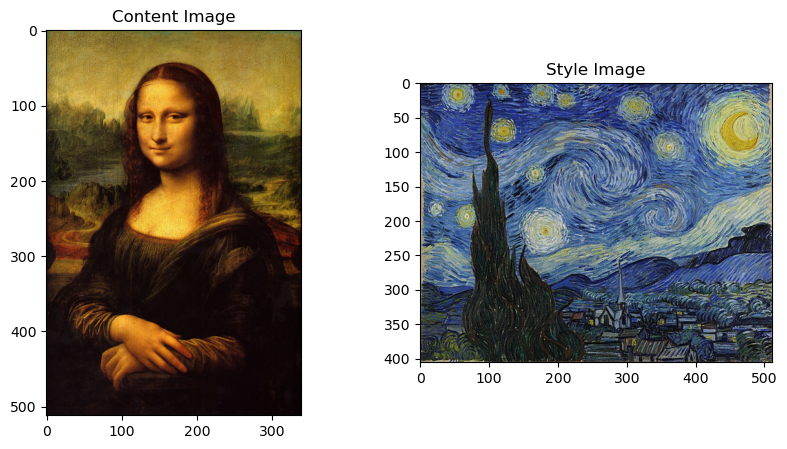

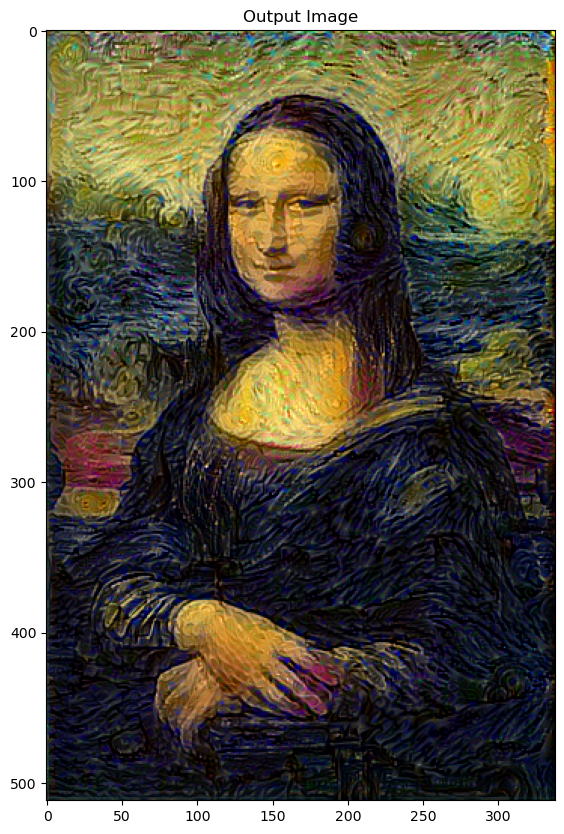

In [18]:
show_results(best, content_path, style_path)

In [19]:
final = Image.fromarray(best)

In [20]:
final.save('output.jpeg')